In [41]:

import numpy as np
import tensorflow as tf
import jax.numpy as jnp
import matplotlib.pyplot as plt 

#TODO: produce help strings 
#TODO: better type annotation
#TODO: implement different initializations 
#TODO: decouple input output from init method in class
#TODO: implement AD with jax 
#TODO: eliminate use of lists , optimize with jax and numba  
#TODO: implement momentum, adam 
#TODO: implement convolutional network 

fire = 1
output_length = 10 

def magnitude(x: np.array) -> (int | float):
    return np.sqrt(np.sum(x**2))
    
def max_normalize(data):
    return data / np.max(data)

def gaussian_normalize(data):
    return (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + 1e-8)    
# @nb.jit()


def relu(z):
    return np.maximum(0, z)

def derivative_relu(z):
    return np.where(z > 0, 1, 0)

def sigmoid(z : (int | float)) -> (int | float, np.array):
    """
    Computes the sigmoid of a given input.

    The sigmoid function is commonly used as an activation function in neural networks.

    Parameters:
    -----------
    z : int or float
        The input value for which the sigmoid function will be computed.

    Returns:
    --------
    int or float
        The computed sigmoid value of the input, in the range (0, 1).

    Note:
    -----
    The function expects scalar inputs. For vectorized inputs (e.g., NumPy arrays),
    consider extending this function or directly using vectorized NumPy operations.
    """
    return 1/(1+np.exp(-z))

def derivative_sigmoid(z : (int | float )) -> (int | float, "np.array")  : 
    """
    Computes the derivative of of a given input.

    The sigmoid function is commonly used as an activation function in neural networks.

    Parameters:
    -----------
    z : int or float
        The input value for which the sigmoid function will be computed.

    Returns:
    --------
    int or float
        The computed sigmoid value of the input, in the range (0, 1).

    Note:
    -----
    The function expects scalar inputs. For vectorized inputs (e.g., NumPy arrays),
    consider extending this function or directly using vectorized NumPy operations.
    """
    sig = sigmoid
    return sig(z) * (1-sig(z))


def mse_grad(a:np.array, y:np.array) -> np.array:
    return (a-y)


def hot_encode(x: np.array, output_length:(int | float)) -> np.array:   
    """
    Converts an array of integer indices into one-hot encoded vectors.

    Parameters:
        x (np.array): Array of integer indices.
        output_length (int): Length of the one-hot encoded vectors.

    Returns:
        np.array: A 2D array where each row is a one-hot encoded vector corresponding to the input indices.
    """   
    tmp = []
    for index in x:
        x_vec = np.zeros(output_length)
        x_vec[int(index)] = fire
        tmp.append(x_vec.reshape((output_length)))
    return np.array(tmp)

def feedforward(x: np.array,σ: callable,n: (int | float), W: "NeuralNetwork.weights",b:"NeuralNetwork.bias")-> np.array:
    """
    Perform a feedforward computation in a neural network.

    Parameters
    ----------
    x : np.array
        The input array to the neural network. Typically a vector or batch of vectors.
    σ : callable
        The activation function applied element-wise at each layer (e.g., ReLU, sigmoid, or tanh).
    n : int | float
        The number of layers in the neural network. Assumes layers are indexed from 0 to n-1.
    W : NeuralNetwork.weights
        A list or array of weight matrices, where `W[l]` is the weight matrix for layer `l`.
        Each matrix should have dimensions suitable for the connections between layers.
    b : NeuralNetwork.bias
        A list or array of bias vectors, where `b[l]` is the bias vector for layer `l`.
        Each vector should have dimensions matching the output size of the respective layer.

    Returns
    -------
    np.array
        The output of the neural network after applying all layers.

    Notes
    -----
    - The function assumes that the number of layers (`n`) matches the length of `W` and `b`.
    - The activation function (`σ`) is applied after the affine transformation at each layer:
      `activation = σ(W[l] @ activation + b[l])`.
    - `x` is treated as the initial activation for layer 0.

    Example
    -------
    >>> import numpy as np
    >>> def relu(x):
    ...     return np.maximum(0, x)
    ...
    >>> x = np.array([1, 2])
    >>> W = [np.array([[0.1, 0.2], [0.3, 0.4]]), np.array([[0.5, 0.6]])]
    >>> b = [np.array([0.1, 0.2]), np.array([0.3])]
    >>> feedforward(x, relu, 2, W, b)
    array([0.77])  # Example output
    """
    
    activation = σ(W[0] @ x + b[0])
    for l in range(1, n):
        activation = σ(W[l] @ activation + b[l])

    return activation

def store_intermediate(feedforward):
    """
    Decorator to modify the feedforward method to store intermediate activations.
    
    Parameters
    ----------
    feedforward_func : function
        The original feedforward function to be wrapped.
    
    Returns
    -------
    function
        A new function that stores intermediate activations.
    """
    @wraps(feedforward)
    def wrapper(x, σ, n, W, b):
        # List to store intermediate activations
        A = []
        Z = []
        # Perform the forward pass, storing intermediate activations at each layer
        z0 = W[0] @ x + b[0]
        a0 = σ(z0)
        a = a0
        Z.append(z0);A.append(a0)  # Store the first activation
        for l in range(1, n):
            z = W[l] @ a + b[l]
            a = σ(z)
            Z.append(z);A.append(a)  # Store the activation at each layer
        
        # Call the original feedforward function (return final result)
        result = a
        
        # Return the result and the list of intermediate activations
        return result, A, Z

    return wrapper

def prepare_data(dataset = 'mnist', normalize_scheme=max_normalize):     
        """
    Prepares and preprocesses a dataset for training and testing.

    Parameters:
        dataset (str): Name of the dataset to load from tf.keras.datasets (default: 'mnist').
        normalize_scheme (function): Function to normalize the dataset (default: max_normalize).

    Returns:
        tuple: Preprocessed training and testing data:
            - x_train (np.array): Flattened and normalized training input data.
            - y_train (np.array): One-hot encoded training labels.
            - x_test (np.array): Flattened and normalized testing input data.
            - y_test (np.array): One-hot encoded testing labels.
        """
            # Dynamically get the dataset
        try:
            dataset_module = getattr(tf.keras.datasets, dataset)
        except AttributeError:
            raise ValueError(f"Dataset '{dataset}' not found in tf.keras.datasets")
        (x_train, y_train), (x_test, y_test) = dataset_module.load_data()
        x_train, y_train = np.array(x_train, dtype=float) , np.array(y_train, dtype=float)

        # Take n number of 28*28 matrices and convert them to 784 vectors 
        (r, m, n), (rt, mt, nt) = x_train.shape, x_test.shape
        dim_x, dim_xt = (r, m*n), (rt, mt*nt)
        x_train, x_test = x_train.reshape(dim_x), x_test.reshape(dim_xt)
       
        y_train, y_test = (hot_encode(y_train, output_length),
                           hot_encode(y_test, output_length))

        # normalize datasets 
        # x_train = (x_train - np.mean(x_train, axis=0)) / (np.std(x_train, axis=0) + 1e-8)
        # x_test = (x_test - np.mean(x_test, axis=0)) / (np.std(x_test, axis=0) + 1e-8)
        x_train,  x_test = map(normalize_scheme, [x_train, x_test])

        return x_train, y_train, x_test, y_test

class NeuralNetwork():
    """
    A class for constructing and training a fully connected neural network.

    Attributes:
        input (np.array): Input training data.
        output (np.array): Expected output labels (e.g., one-hot encoded).
        hidden_layer_n (int): Number of hidden layers in the network.
        layer_n (int): Total number of layers (input + hidden + output).
        layer_sizes (np.array): List of sizes for each layer in the network.
        bias (list): List of bias vectors for each layer.
        weights (list): List of weight matrices connecting the layers.
        activation_f (callable): Activation function (default: sigmoid).
        activation_df (callable): Derivative of the activation function.
        cost_function (callable): Cost function for training (if provided).

    Methods:
        train(minibatch=True, minibatch_pool=10, iterations=100, η=1e-6) -> 'NeuralNetwork':
            Trains the neural network using gradient descent.

    Parameters:
        input (np.array): Input training data, where each row is a training example.
        output (np.array): Output labels for the training data.
        hidden_layer (int): Number of hidden layers in the network.
        layer_sizes (list[int | float]): List of hidden layer sizes (default: [10]).
        activation_function (callable): Activation function for all layers (default: sigmoid).
        activation_derivative (callable): Derivative of the activation function (default: derivative_sigmoid).
        cost (callable): Cost function to minimize during training (optional).
        dtype (type): Data type for the network parameters (default: float).

    Train Method Parameters:
        minibatch (bool): Whether to use mini-batch gradient descent (default: True).
        minibatch_pool (int | float): Number of samples per mini-batch (default: 10).
        iterations (int | float): Number of training iterations (default: 100).
        η (int | float): Learning rate for gradient descent (default: 1e-6).

    Returns:
        NeuralNetwork: The trained neural network object.

    Example:
        nn = NeuralNetwork(input=x_train, 
                           output=y_train, 
                           hidden_layer=2, 
                           layer_sizes=[64, 32], 
                           activation_function=sigmoid, 
                           activation_derivative=derivative_sigmoid)
        nn.train(minibatch=True, minibatch_pool=32, iterations=1000, η=0.01)
    """

    def __init__(self,
                 layer_sizes: (list[int] | list[float]) = [10] ,
                 activation_function: callable = sigmoid, 
                 activation_derivative: callable = derivative_sigmoid,
                 cost_function: callable = None, 
                 cost_grad: callable = mse_grad) -> 'NeuralNetwork':
        
        self.layer_sizes = layer_sizes
        self.layer_n = len(self.layer_sizes)
        self.hidden_layer_n = len(self.layer_sizes)-2
        self.bias = [np.random.randn(self.layer_sizes[i])
                     for i in range(1, self.hidden_layer_n+2)] 
    
        self.weights = [np.random.randn(self.layer_sizes[i], 
                                          self.layer_sizes[i-1]) * np.sqrt(1/self.layer_sizes[i-1])
                        for i in range(1, self.hidden_layer_n+2)]
        
        
        self.activation_f = activation_function
        self.activation_df= activation_derivative
        self.cost = cost_function
        self.cost_grad = cost_grad


    def train(self,
              input, 
              output, 
              minibatch: bool = True,
              minibatch_pool : (int | float) = 10,
              iterations: (int | float) = 100,
              η: (int | float) = 1e-6) -> None:
        """
    Trains the neural network using gradient descent.

    Parameters:
        minibatch (bool): Whether to use mini-batch gradient descent (default: True).
        minibatch_pool (int | float): Size of the mini-batch for training (default: 10).
        iterations (int | float): Number of training iterations (default: 100).
        η (int | float): Learning rate for gradient descent (default: 1e-6).

    Returns:
        NeuralNetwork: The trained neural network object.

    Description:
        - Implements forward propagation for each input to compute activations.
        - Performs backpropagation to compute gradients for weights and biases.
        - Updates weights and biases using gradient descent.
        - Supports mini-batch gradient descent if `minibatch` is set to True.

    Example:
        nn.train(minibatch=True, minibatch_pool=32, iterations=1000, η=0.01)
        """
        
        for _ in range(iterations):

            if minibatch:
                indexes = np.random.choice(input.shape[0], size=minibatch_pool)
                X, Y = input[indexes], output[indexes]
            else: 
                X, Y = input, output


            a_errors = [np.zeros(matrix.shape) for matrix in self.weights]

            b_errors = [np.zeros(vector.shape) for vector in self.bias]

            # iterate for each set of x and y
            # find zs and as (pre-act and activation)
            for x, y in zip(X, Y): 
                # print("x id:",id(x))
                z0 = self.weights[0] @ x + self.bias[0]
                zs = [z0]
                a0 = self.activation_f(z0)
                activations = [a0]
                for l in range(1, self.layer_n-1,1):
                    # print("layers:",l,l-1)
                    zl = self.weights[l] @ activations[l-1] + self.bias[l]
                    activation = self.activation_f(zl)
                    # print("activation:", activation)
                    zs.append(zl)
                    activations.append(activation)  

                z_output = zs[-1]
                a_output = activations[-1]
                output_error = self.cost_grad(a_output,y) * self.activation_df(z_output)
                errors = [output_error]
                for l in range(self.hidden_layer_n, 0, -1):
                    error = self.weights[l].T @ errors[-1] * self.activation_df(zs[l-1])
                    errors.append(error)

                errors.reverse()
                # compute sum of error
                for l in range(0,self.hidden_layer_n+1,1):
                    # a_errors[l] += errors[l]@activations[l].T
                    a_errors[l] += np.outer(errors[l], activations[l-1]  if l > 0 else x)
                    # print(a_errors)
                    b_errors[l] += errors[l] 
                        # print(b_errors)


            # gradient descent 
            for l in range(0, self.hidden_layer_n+1):
                self.weights[l] -= η / minibatch_pool * a_errors[l]
                self.bias[l] -= η / minibatch_pool * b_errors[l]
            


    def predict(self, 
                input: list[np.array]) -> list[np.array]:
        
        """
    Predicts the output for a given input using the trained neural network.

    Parameters:
        input (np.array): Input data to predict, where each row corresponds to a single input instance.

    Returns:
        list: A list of predictions where each prediction corresponds to the output of the neural network
              for the corresponding input instance.

    Description:
        - Performs forward propagation through the network to compute the output layer activations.
        - Returns the final layer activations as predictions.

    Example:
        predictions = nn.predict(x_test)
        """
        
        results = [ ]
        for x in input : 
            # print(x,"\n")
            z0 = self.activation_f(self.weights[0] @ x + self.bias[0])
            activations = [z0]
            for l in range(1, self.layer_n-1):
                zl = self.weights[l] @ activations[l-1] + self.bias[l]
                a = self.activation_f(zl)
                activations.append(a) 
        
            results.append(activations[-1])

        return results
    

import numpy as np 
import matplotlib.pyplot as plt
import os
os.chdir('..')
import src.neural_network as nn 


def l2_hinge_loss_gradient(activations, one_hot_label):
    """
    Computes the gradient of L2 multi-class hinge loss for a single instance.

    Args:
        activations (np.ndarray): Activations (logits) for a single instance (shape: (C,)).
        one_hot_label (np.ndarray): One-hot encoded label (shape: (C,)).

    Returns:
        np.ndarray: Gradient of the L2 hinge loss with respect to activations (shape: (C,)).
    """
    # Find the index of the correct class
    y_index = np.argmax(one_hot_label)
    
    # Initialize gradient
    grad = np.zeros_like(activations)
    
    # Compute margin for each class
    for j in range(len(activations)):
        if j == y_index:
            continue  # Skip the correct class for now
        
        margin = 1 + activations[j] - activations[y_index]
        if margin > 0:
            grad[j] = 2 * margin
            grad[y_index] -= 2 * margin  # Accumulate gradient for the correct class
    
    return grad


def step(x:np.array,x2: (int | float)=.5) -> np.array:
    """
    Renames the piecewise function htanh(x).
    
    Args:
        x: A scalar or NumPy array.
        
    Returns:
        A NumPy array with the heaviside transformation applied element-wise.
    """
    return np.heaviside(x,x2)

def htanh(x):
    """
    Implements the piecewise function htanh(x).
    
    Args:
        x: A scalar or NumPy array.
        
    Returns:
        A NumPy array with the htanh transformation applied element-wise.
    """
    return np.where(x < -1, -1, np.where(x > 1, 1, x))


def derivative_htanh(x):
    """
    Implements the derivative of piecewise function htanh(x).
    
    Args:
        x: A scalar or NumPy array.
        
    Returns:
        A NumPy array with the htanh transformation applied element-wise.
    """
    return np.where(x < -1, 0, np.where(x > 1, 0, 1))

class NeuralNetworkwMemory(NeuralNetwork):
    def train(self,
              input, 
              output, 
              minibatch: bool = True,
              minibatch_pool : (int | float) = 10,
              iterations: (int | float) = 100,
              η: (int | float) = 1e-6) -> list[np.array]:
        """
        Trains the neural network using gradient descent.

        Parameters:
            minibatch (bool): Whether to use mini-batch gradient descent (default: True).
            minibatch_pool (int | float): Size of the mini-batch for training (default: 10).
            iterations (int | float): Number of training iterations (default: 100).
            η (int | float): Learning rate for gradient descent (default: 1e-6).

        Returns:
            NeuralNetwork: The trained neural network object.

        Description:
            - Implements forward propagation for each input to compute activations.
            - Performs backpropagation to compute gradients for weights and biases.
            - Updates weights and biases using gradient descent.
            - Supports mini-batch gradient descent if `minibatch` is set to True.

        Example:
            nn.train(minibatch=True, minibatch_pool=32, iterations=1000, η=0.01)
        """
        
        weight_history = []

        for _ in range(iterations):

            if minibatch:
                indexes = np.random.choice(input.shape[0], size=minibatch_pool)
                X, Y = input[indexes], output[indexes]
            else: 
                X, Y = input, output


            a_errors = [np.zeros(matrix.shape) for matrix in self.weights]

            b_errors = [np.zeros(vector.shape) for vector in self.bias]

            # iterate for each set of x and y
            # find zs and as (pre-act and activation)
            for x, y in zip(X, Y): 
                # print("x id:",id(x))
                z0 = self.weights[0] @ x + self.bias[0]
                zs = [z0]
                a0 = self.activation_f(z0)
                activations = [a0]
                for l in range(1, self.layer_n-1,1):
                    # print("layers:",l,l-1)
                    zl = self.weights[l] @ activations[l-1] + self.bias[l]
                    activation = self.activation_f(zl)
                    # print("activation:", activation)
                    zs.append(zl)
                    activations.append(activation)  

                z_output = zs[-1]
                a_output = activations[-1]
                output_error = self.cost_grad(a_output,y) * self.activation_df(z_output)
                errors = [output_error]
                for l in range(self.hidden_layer_n, 0, -1):
                    error = self.weights[l].T @ errors[-1] * self.activation_df(zs[l-1])
                    errors.append(error)

                errors.reverse()
                # compute sum of error
                for l in range(0,self.hidden_layer_n+1,1):
                    # a_errors[l] += errors[l]@activations[l].T
                    a_errors[l] += np.outer(errors[l], activations[l-1]  if l > 0 else x)
                    # print(a_errors)
                    b_errors[l] += errors[l] 
                        # print(b_errors)


            # gradient descent 
            for l in range(0, self.hidden_layer_n+1):
                self.weights[l] -= η / minibatch_pool * a_errors[l]
                self.bias[l] -= η / minibatch_pool * b_errors[l]
            

            weight_history.append(self.weights)

        return weight_history
    


  



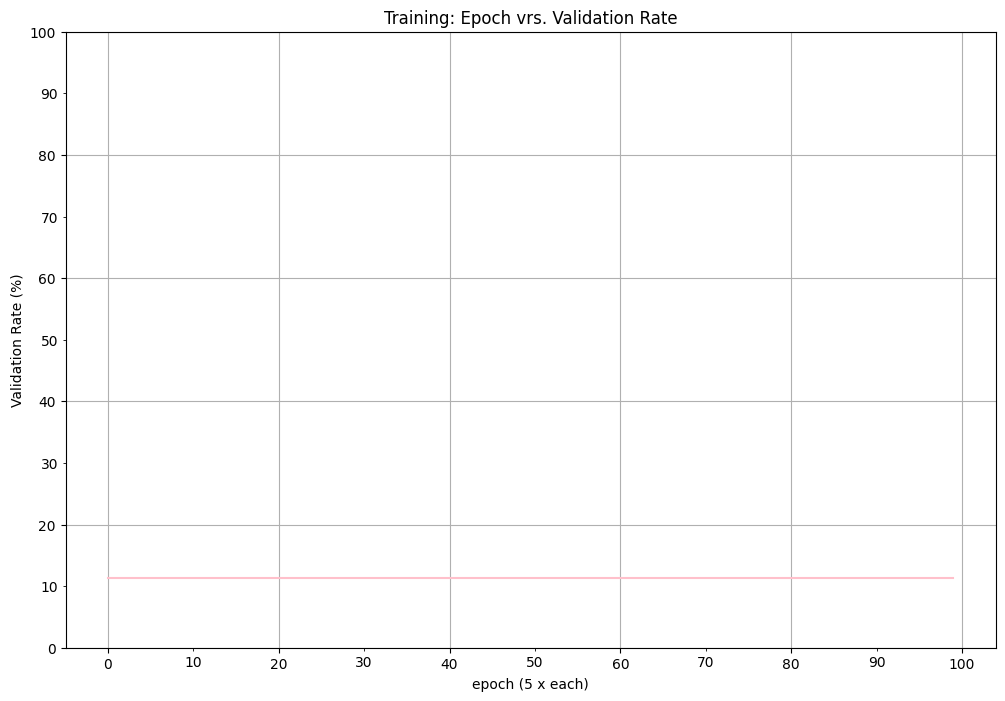

In [ ]:
x_train, y_train, x_test, y_test = nn.prepare_data()

x_train, x_test = np.round(x_train), np.round(x_test)

n_x, n_y = 784, 10  

net = NeuralNetworkwMemory([n_x,
                         512, 
                         512, 
                         512, 
                         n_y],
                       activation_function=step,
                       activation_derivative=derivative_htanh,
                       cost_grad=l2_hinge_loss_gradient)


validation_rate = []
for run in range(0, 1000):
    net.train(x_train, y_train, minibatch_pool=32, iterations=5, η=.3)
    results = net.predict(x_test)
    rate = np.sum(
            np.array(list(map(np.argmax, results)))
            == np.array(list(map(np.argmax, y_test)))
        )
    validation_rate.append(rate / len(x_test) * 100)

plt.figure(figsize=(12, 8))
plt.plot(validation_rate, label=r"η=3", color="pink")
plt.title(r"Training: Epoch vrs. Validation Rate")
plt.xlabel("epoch (5 x each)")
plt.ylabel("Validation Rate (%)")
ticks = np.arange(0, 101, 10)
plt.xticks(ticks, labels=ticks.astype(str), minor=True)
plt.yticks(ticks, labels=ticks.astype(str), minor=True)
plt.grid()
plt.show()

In [69]:
# form triadigonal M matrix 


net = NeuralNetworkwMemory([n_x,
                         512, 
                         512, 
                         512, 
                         n_y],
                       activation_function=step,
                       activation_derivative=derivative_htanh,
                       cost_grad=l2_hinge_loss_gradient)

weight_history = net.train(x_train, y_train, minibatch_pool=64, iterations=960, η=1e-4)


In [ ]:
n = len(net.weights)

def make_R(layer):
    return 0 

M = [[0 for _ in range(n)] for _ in range(n)]

for i in range(0,n): 
    for j in range(0,n):
        if i == j :
           R = make_R(i) 
           M[i][j] = R
        else: 
           M[i,j] = weight_history[i-1].T

        




[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]

array([[1, 1, 1],
       [1, 1, 1]])

In [78]:
import numpy as np

def block_tridiagonal(blocks):
    """
    Create a block tridiagonal matrix with zero blocks on the diagonal.
    
    Parameters:
        blocks (list of numpy arrays): A list of 2D NumPy arrays representing the off-diagonal blocks.
    
    Returns:
        numpy.ndarray: The resulting block tridiagonal matrix.
    """
    num_blocks = len(blocks)
    block_size = blocks[0].shape[0]
    total_size = num_blocks * block_size

    # Initialize the full block matrix with zeros
    block_matrix = np.zeros((total_size, total_size))

    # Place the off-diagonal blocks
    for i in range(num_blocks - 1):
        block_matrix[i * block_size:(i + 1) * block_size, (i + 1) * block_size:(i + 2) * block_size] = blocks[i]
        block_matrix[(i + 1) * block_size:(i + 2) * block_size, i * block_size:(i + 1) * block_size] = blocks[i]

    return block_matrix

# Example usage
M1 = np.array([[1, 2], [3, 4]])
M2 = np.array([[5, 6], [7, 8]])
M3 = np.array([[9, 10], [11, 12]])

# List of off-diagonal blocks
blocks = [M1, M2, M3]

# Generate the block tridiagonal matrix
result = block_tridiagonal(blocks)

# Print the result
print(result)

[[0. 0. 1. 2. 0. 0.]
 [0. 0. 3. 4. 0. 0.]
 [1. 2. 0. 0. 5. 6.]
 [3. 4. 0. 0. 7. 8.]
 [0. 0. 5. 6. 0. 0.]
 [0. 0. 7. 8. 0. 0.]]


In [ ]:
import numpy as np
import numpy as np

#TODO: generalize this method

def block_tridiagonal_with_transpose(blocks):
    """
    Create a block tridiagonal matrix with zero blocks on the diagonal and 
    each block transposed in the row below where it first appears, supporting varying block sizes.
    
    Parameters:
        blocks (list of numpy arrays): A list of 2D NumPy arrays representing the off-diagonal blocks.
    
    Returns:
        numpy.ndarray: The resulting block tridiagonal matrix.
    """
    # Validate that blocks have consistent row and column relationships
    for i in range(len(blocks) - 1):
        if blocks[i].shape[1] != blocks[i + 1].shape[1]:
            raise ValueError(f"Block {i} column size ({blocks[i].shape[1]}) does not match "
                             f"Block {i+1} row size ({blocks[i+1].shape[0]}).")

    # Calculate the total size of the block matrix
    total_rows = sum(block.shape[0] for block in blocks)
    total_cols = total_rows  # Square block matrix

    # Initialize the block matrix with zeros
    block_matrix = np.zeros((total_rows, total_cols))

    # Place off-diagonal blocks and their transposes
    current_row = 0
    for i, block in enumerate(blocks):
        next_row = current_row + block.shape[0]
        next_col = current_row + block.shape[1]

        if i < len(blocks) - 1:
            # Place block in the upper off-diagonal
            block_matrix[current_row:next_row, next_row:next_row + block.shape[1]] = block
            # Place the transposed block in the lower off-diagonal
            block_matrix[next_row:next_row + block.shape[1], current_row:next_row] = block.T

        current_row += block.shape[0]

    return block_matrix
# Example usage
M1 = np.array([[1, 2], [3, 4]])
M2 = np.array([[5, 6], [7, 8]])
M3 = np.array([[9, 10], [11, 12]])

# List of off-diagonal blocks
blocks = [M1, M2, M3]

# Generate the block tridiagonal matrix
result = block_tridiagonal_with_transpose(weight_history[0])

# Print the result


ValueError: Block 0 row size (784) does not match Block 1 row size (512).

In [ ]:
def form_R(β:(int | float ), weights:list[np.array]) -> list[np.array]:
    Rs = []
    L = len(weights)
    for l in range(0,L): 
        if l == 0 :
            R0 = []
            (m, _) , J0 = weights[0].shape, weights[0]
            for i in range(0,m):
                R0.append(-β* sum(J0[i,:]**2))
        if  0 < l < L-1:
            Rk = []
            (m, _) , JL1,JL = weights[l-1].shape, weights[l], weights[l-1]
            for i in range(0,m):
                row = [ ]
                for j in range(0,n):
                    if i != j :
                        row.append(0)
                    if i == j :
                        row.append(-β* ( sum(JL[:,i]**2) + sum(JL1[i]**2)) )
                Rk.append(row)
            Rs.append(np.array(Rk).T)

        else: 
            RL = []
            (m, n) , JL = weights[L-1].shape, weights[L-1]
            for i in range(0,m):
                row = [ ]
                for j in range(0,n):
                    if i != j :
                        row.append(0)
                    if i == j :
                        row.append(-β* sum(JL[:, i]**2))
                RL.append(row)
            Rs.append(np.array(RL).T)

    return Rs



Rs=form_R(β=2, weights=weight_history[0])

J = weight_history[0]


z1 = np.zeros(Rs[0].shape)
z2 = np.zeros(J[1].shape)
z3 = np.zeros(J[2].shape)
M = [ [Rs[0], J[0],0,0,0], 
        [J[0].T, Rs[1],J[1],0,0],
        [0,J[1].T, Rs[2],J[2],0],
        [0,0,J[2].T,Rs[3],J[3]],
        [0,0,0,J[3].T, Rs[4]]]

# def form_M(weights):


J[0].shape


(512, 784)

In [195]:
Rs[0].shape

(512, 784)

In [ ]:
β = 1 
RL = []
(m, n) , JL = weight_history[0][3].shape, weight_history[0][3]
for i in range(0,m):
    row = [ ]
    for j in range(0,n):
        if i != j :
            row.append(0)

        if i == j :

            row.append(-β* sum(JL[:, j]**2))
                  
    RL.append(row)



array([[-0.01870085,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.01419157,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.01405076, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [132]:
Rk = []

(m, n) , JL1,JL = weight_history[0][1].shape, weight_history[0][1], weight_history[0][0]
for i in range(0,m):
    row = [ ]
    for j in range(0,n):
        if i != j :
            row.append(0)
        if i == j :
            row.append(-β* ( sum(JL[:,i]**2) + sum(JL1[i]**2)) )
                  
    Rk.append(row)

np.array(Rk)

array([[-1.62648788,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -1.56493599,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -1.69095368, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.70394971,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -1.64436159,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -1.5908167 ]])

In [140]:
form_R(1, weight_history[0])

0


TypeError: list indices must be integers or slices, not tuple

In [209]:
weights = weight_history[0]
R0 = []
(m, _) , J0 = weights[0].shape, weights[0]
for i in range(0,m):
    R0.append(-β* sum(J0[i,:]**2))

np.diag(R0).shape

(512, 512)

In [ ]:
R0[0].shape

AttributeError: 'list' object has no attribute 'shape'

In [205]:
weights[0].shape

(512, 784)

In [235]:
l=1
Rk1 = []
Rk2 = []
(_, n) , (m,_),Jl_1,Jl = weights[l-1].shape, weights[l].shape, weights[l], weights[l-1]


for i in range(0,n):
    Rk1.append((sum(Jl[:,i]**2)) )


print(len(Jl_1))
for j in range(0,m):

    Rk2.append((sum(Jl_1[i,:]**2)) )


len(Jl_1)

512


IndexError: index 783 is out of bounds for axis 0 with size 512

In [222]:
J[1].shape

(512, 512)

In [214]:
J[0].shape

(512, 784)

In [253]:
def linearized_TAP(J, m, β ):
    """
    
    
    """
    D = np.diag(1-m**2)
    d = np.diag(J**2*(1-m**2))
    return 1 - D @ J + β*D @ d

In [239]:
linearized_TAP(weight_history[0][0],x_train[0],1)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 512 is different from 784)

In [274]:
J = weight_history[0][0]
m = x_train[0]
D = np.diag(1-m**2)
d = np.diag(J**2 @ (1-m**2))

print(d.shape)

(512, 512)


In [277]:
J.shape

(512, 784)

In [281]:
weight_history[0][3].shape

(10, 512)

In [283]:
784+512+512+512+10

784+512*4

2832

In [372]:
W = weight_history[0]
o_00 = np.zeros((784,784))
o_02 = np.zeros((784,512))
o_03 = np.zeros((784,10))
o_10 = np.zeros((512,512))
o_11 = np.zeros((512,10))
o_12 = np.zeros((10,10))


J = [
          
          [o_00,        W[0].T,      o_02,       o_02,       o_03 ] ,
          [ W[0],       o_10,        W[1].T,     o_10,       o_11]  ,
          [o_02.T,      W[1],        o_10,       W[2].T,     o_11 ] ,
          [o_02.T,      o_10,        W[2],       o_10,       W[3].T] , 
          [o_03.T,      o_11.T,      o_11.T,     W[3],       o_12 ]
          
          ]

# m = n = 2330
J = np.block(J)


def form_M(J, β, inplace=False):
    if inplace is False: 
        J_  = J.copy()
    else: 
        J_ = J 
    J_ = β * J_

        # Add the diagonal correction
    diagonal_correction = β**2 * np.sum(J_**2, axis=1)
    np.fill_diagonal(J_, np.diagonal(J_) + diagonal_correction)
    return J_

M = form_M(J, β=1)

eig_M = np.linalg.eig(1-M)    

(array([2.329e+03, 1.000e+00]),
 array([  -4.38463153, 1162.12574258, 2328.63611669]),
 <BarContainer object of 2 artists>)

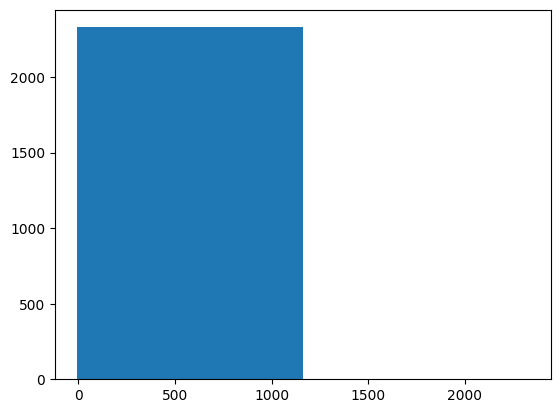

In [376]:
plt.hist(eig_M.eigenvalues,bins=2)

In [360]:
M

[[array([[-2.06968777,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        , -1.80358165,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        , -1.99435419, ...,  0.        ,
           0.        ,  0.        ],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ]]),
  array([[-0.00029609,  0.04906848, -0.0575105 , ..., -0.0089513 ,
           0.01739463, -0.0244129 ],
         [-0.00233965, -0.05187616,  0.05180787, ...,  0.028442  ,
          -0.03902454,  0.01658924],
         [-0.01488027,  0.0552667 , -0.07325578, ..., -0.03752571,
           0.0197217 ,  0.03008509],
         ...,
         [-0.00219633, -0.06887786